<a href="https://colab.research.google.com/github/Cracen26/Tangible-Object-Detection-With-MobileNetV2-VGG16/blob/main/SGB_Transfert_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.applications import VGG16
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import tensorflow as tf
import pandas as pd
import numpy as np
import imutils
from imutils import paths
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

# /content/drive/MyDrive/ColabNotebooks/dataset/gameboard

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = "/content/drive/MyDrive/ColabNotebooks/dataset/gameboard"
train_images = os.path.sep.join([base_path, 'train'])
train_annotations = os.path.sep.join([base_path, 'train/train.csv'])
valid_images = os.path.sep.join([base_path, 'valid'])
valid_annotations = os.path.sep.join([base_path, 'valid/valid.csv'])

In [ ]:
#Defining class labels

classes = 10

label_to_class_names = {
    0: 'blue_tag',
    1: 'green_tag',
    2: 'yellow_tag',
    3: 'orange_tag',
    4: 'red_tag'
}

#One hot encoded labels
encode_classname = {}

for label, class_name in label_to_class_names.items():
  one_hot_encoding = [0] * len(label_to_class_names)
  one_hot_encoding[label] = 1

  # Add the one-hot encoding to the dictionary
  encode_classname[class_name] = one_hot_encoding

print(encode_classname)

{'blue_tag': [1, 0, 0, 0, 0], 'green_tag': [0, 1, 0, 0, 0], 'yellow_tag': [0, 0, 1, 0, 0], 'orange_tag': [0, 0, 0, 1, 0], 'red_tag': [0, 0, 0, 0, 1]}


In [ ]:
df = pd.read_csv(train_annotations)
valdf = pd.read_csv(valid_annotations)
df

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,blue_tag,607,341,166,170,1.jpg,2016,1512
1,orange_tag,1390,619,149,185,1.jpg,2016,1512
2,green_tag,1103,938,188,179,1.jpg,2016,1512
3,blue_tag,445,400,147,149,10.jpg,1512,2016
4,green_tag,1067,383,154,176,10.jpg,1512,2016
...,...,...,...,...,...,...,...,...
122,yellow_tag,445,783,179,184,9.jpg,1512,2016
123,yellow_tag,918,1027,169,176,9.jpg,1512,2016
124,yellow_tag,652,1484,179,194,9.jpg,1512,2016
125,red_tag,905,567,157,176,9.jpg,1512,2016


In [ ]:
def prepare_dataset(df,images, encode_classname):
  # Initialize empty lists for image data, bounding box coordinates, and labels
  imgarray=[]
  bbox=[]
  labels=[]

  # Iterate over the rows of the data DataFrame
  for idx, row in df.iterrows():
    # Extract the image name, label, and bounding box coordinates from the DataFrame
    image_name = row.iloc[5]
    label = row.iloc[0]
    bboxX = row.iloc[1]
    bboxY = row.iloc[2]
    width = row.iloc[3]
    height = row.iloc[4]

    #Adjusting boundary boxes in resized image
    imagepaths=os.path.sep.join([images,image_name])
    image=cv2.imread(imagepaths)
    (h,w)=image.shape[:2]

    # Adjust the bounding box coordinates to the new dimensions of the resized image
    bboxX = float(bboxX) / w
    bboxY = float(bboxY) / h
    height = float(height) / w
    width = float(width) / h

    # Load and resize the image, then convert it to a NumPy array
    image=load_img(imagepaths,target_size=(224,224))
    image=img_to_array(image)

    # Append the image data, bounding box coordinates, and one-hot encoded label to the respective lists
    imgarray.append(image)
    bbox.append((bboxX,bboxY,height,width))
    labels.append(encode_classname[label])

  # Normalize the image data
  imgarray=np.array(imgarray,dtype='float32') / 255.0
  bbox=np.array(bbox,dtype='float32')
  labels = np.array(labels)

  return imgarray, bbox, labels

In [ ]:
# Prepare the training dataset
train_imgdata, train_bbox, train_labels = prepare_dataset(df,train_images, encode_classname)
train_imgdata.shape, train_bbox.shape, train_labels.shape

((127, 224, 224, 3), (127, 4), (127, 5))

In [ ]:
# Prepare the Validation dataset
val_imgdata, val_bbox, val_labels = prepare_dataset(valdf,valid_images, encode_classname)
val_imgdata.shape, val_bbox.shape, val_labels.shape

((18, 224, 224, 3), (18, 4), (18, 5))

In [ ]:
# Load the MobileNetV2 model pre-trained on ImageNet
mobilenet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',input_shape=(224,224,3))
mobilenet.trainable = False

# Customize the layers of the model
x = mobilenet.output
x = Flatten()(x)

# Add fully-connected layers to the model
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# Add an output layer for the bounding box predictions
bbox_output = Dense(4, activation='sigmoid', name='bounding_box')(x)

# Add fully-connected layers to the model
l = Dense(512, activation="relu")(x)
l = Dropout(0.2)(l)
l = Dense(128, activation="relu")(l)
l = Dropout(0.2)(l)

# Add an output layer for the class label predictions
label_output = Dense(5, activation='softmax', name='class_label')(l)

# Create a model with the customized layers
mobilenet = Model(mobilenet.input, [label_output, bbox_output])

# Print a summary of the model
mobilenet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

lossWeights = {
	"class_label": 5,
	"bounding_box": 5
}

mobilenet.compile(
    optimizer=Adam(0.00001),
    loss=losses,
    loss_weights=lossWeights,metrics=['accuracy']
)
# train model for 100 epochs
historymobilenet = mobilenet.fit(
    train_imgdata,
    [train_labels, train_bbox],
    validation_data=(val_imgdata,[val_labels,val_bbox]),
    batch_size = 16,
    epochs = 100,
    verbose = 1,
)

Epoch 1/100
8/8 [==============================] - 13s 844ms/step - loss: 8.2951 - class_label_loss: 1.6314 - bounding_box_loss: 0.0276 - class_label_accuracy: 0.1811 - bounding_box_accuracy: 0.5984 - val_loss: 7.9732 - val_class_label_loss: 1.5599 - val_bounding_box_loss: 0.0347 - val_class_label_accuracy: 0.2222 - val_bounding_box_accuracy: 0.7222
Epoch 2/100
8/8 [==============================] - 7s 984ms/step - loss: 8.1525 - class_label_loss: 1.5954 - bounding_box_loss: 0.0351 - class_label_accuracy: 0.2205 - bounding_box_accuracy: 0.5827 - val_loss: 7.9019 - val_class_label_loss: 1.5399 - val_bounding_box_loss: 0.0404 - val_class_label_accuracy: 0.3333 - val_bounding_box_accuracy: 0.7222
Epoch 3/100
8/8 [==============================] - 5s 643ms/step - loss: 8.0249 - class_label_loss: 1.5712 - bounding_box_loss: 0.0338 - class_label_accuracy: 0.1969 - bounding_box_accuracy: 0.5984 - val_loss: 7.8129 - val_class_label_loss: 1.5228 - val_bounding_box_loss: 0.0398 - val_class_label

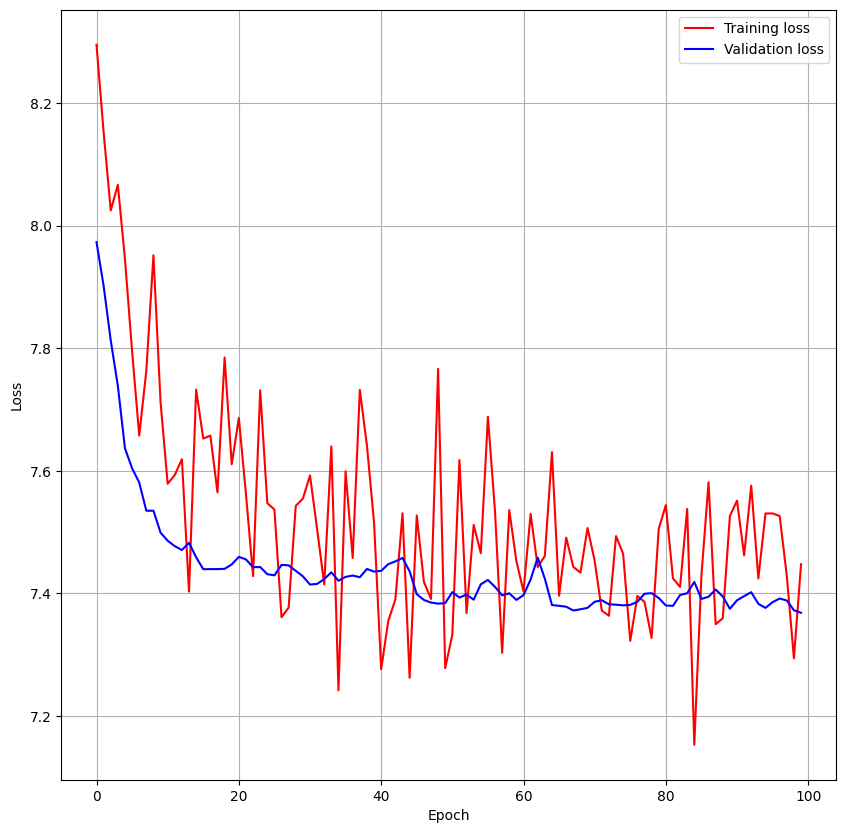

In [ ]:
plt.figure(figsize=(10, 10))

loss = historymobilenet.history['loss']
val_loss = historymobilenet.history['val_loss']

# plot the losses
plt.plot(loss, label='Training loss', color='red')
plt.plot(val_loss, label='Validation loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
mobilenet.save(os.path.sep.join([base_path,'model/mobilenetv2v1.h5']))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
vgg.trainable = False

# Customize the layers of the model
x = vgg.output
x = Flatten()(x)

# Add fully-connected layers to the model
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# Add an output layer for the bounding box predictions
bbox_output = Dense(4, activation='sigmoid', name='bounding_box')(x)

# Add fully-connected layers to the model
l = Dense(512, activation="relu")(x)
l = Dropout(0.2)(l)
l = Dense(128, activation="relu")(l)
l = Dropout(0.2)(l)

# Add an output layer for the class label predictions
label_output = Dense(5, activation='softmax', name='class_label')(l)

vgg = Model(vgg.input, [label_output, bbox_output])


# model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'], metrics=['accuracy'])
vgg.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_8[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [ ]:
vgg.compile(
    optimizer=Adam(0.00001),
    loss=losses,
    loss_weights=lossWeights,metrics=['accuracy']
)
# train model for 100 epochs
historyvgg = vgg.fit(
    train_imgdata,
    [train_labels, train_bbox],
    validation_data=(val_imgdata,[val_labels,val_bbox]),
    batch_size = 16,
    epochs = 100,
    verbose = 1,
)

Epoch 1/100
8/8 [==============================] - 105s 13s/step - loss: 8.2560 - class_label_loss: 1.6156 - bounding_box_loss: 0.0356 - class_label_accuracy: 0.1654 - bounding_box_accuracy: 0.4488 - val_loss: 8.1006 - val_class_label_loss: 1.5838 - val_bounding_box_loss: 0.0363 - val_class_label_accuracy: 0.2222 - val_bounding_box_accuracy: 0.2778
Epoch 2/100
8/8 [==============================] - 98s 12s/step - loss: 8.1464 - class_label_loss: 1.5942 - bounding_box_loss: 0.0351 - class_label_accuracy: 0.2047 - bounding_box_accuracy: 0.4488 - val_loss: 8.0475 - val_class_label_loss: 1.5749 - val_bounding_box_loss: 0.0346 - val_class_label_accuracy: 0.2222 - val_bounding_box_accuracy: 0.2778
Epoch 3/100
8/8 [==============================] - 88s 11s/step - loss: 8.1259 - class_label_loss: 1.5920 - bounding_box_loss: 0.0331 - class_label_accuracy: 0.2283 - bounding_box_accuracy: 0.4488 - val_loss: 7.9934 - val_class_label_loss: 1.5658 - val_bounding_box_loss: 0.0328 - val_class_label_ac

In [ ]:
plt.figure(figsize=(10, 10))

loss = historyvgg.history['loss']
val_loss = historyvgg.history['val_loss']

# plot the losses
plt.plot(loss, label='Training loss', color='red')
plt.plot(val_loss, label='Validation loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# vgg.save(os.path.sep.join([base_path,'model/vgg16.h5']))

In [ ]:
def predict_image(image_path, model):
  # load the image and pre-process it
  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  # predict the bounding box of the object along with the class
  (label_preds, box_preds) = model.predict(image)

  return label_preds, box_preds

def plot_image(image_path, label_pred, box_pred):
  # load the image and resize it
  image = cv2.imread(image_path)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]

  # scale the predicted bounding box coordinates based on the image dimensions
  bboxX, bboxY, width, height = box_pred[0]
  bboxX = int(bboxX * w)
  bboxY = int(bboxY * h)
  width = int(width * w)
  height = int(height * h)

  # get the class label
  label = label_to_class_names[np.argmax(label_pred)]

  # draw the predicted bounding box and class label on the image
  y = bboxY - 10 if bboxY - 10 > 10 else bboxY + 10
  cv2.putText(image, label, (bboxX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
  cv2.rectangle(image, (bboxX, bboxY), (width, height), (0, 255, 0), 2)

  # show the output image
  cv2_imshow(image)

In [ ]:
headphone=os.path.sep.join([base_path,'test/11.jpg'])
labelprediction, bboxprediction = predict_image(headphone,vgg)
print(label_to_class_names[np.argmax(labelprediction)])
print(bboxprediction)
plot_image(headphone,labelprediction,bboxprediction)

1/1 [==============================] - 0s 95ms/step
blue_tag
[[0.5551723  0.4864572  0.13118036 0.22598934]]


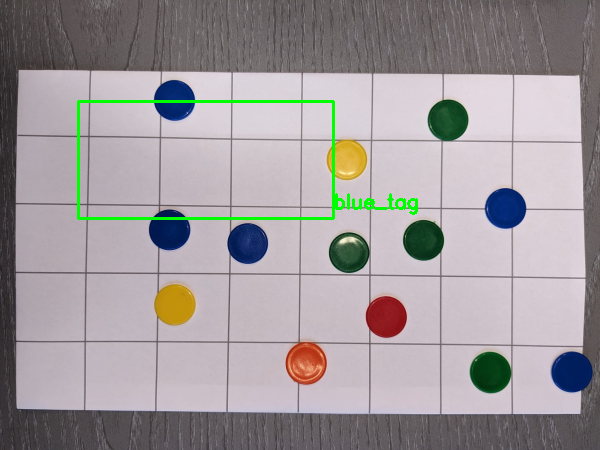

In [ ]:
headphone=os.path.sep.join([base_path,'test/11.jpg'])
labelprediction, bboxprediction = predict_image(headphone,mobilenet)
print(label_to_class_names[np.argmax(labelprediction)])
print(bboxprediction)
plot_image(headphone,labelprediction,bboxprediction)